# TM10007 Assignment template

In [59]:
## Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


# Importing packages

In [60]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Scoring methods
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import decomposition

# Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [61]:
# Data loading
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')





The number of samples: 115
The number of columns: 494


## Creating a split in the data

A training and test set are created. The training set will be used to fit the classifier, while the test set is remained untouched until it is used for testing the trained classifier.

Split is stratified so labels are present in both sets in same proportions.

In [62]:
# Extract columns with labels
Y = data.pop('label').replace({'lipoma':0, 'liposarcoma':1}) #moeten we misschien nog ook de ID poppen?
print(f'Proportion of the labels: {sum(Y)/len(Y)}')

# Extract the rest of the data (without the labels)
X = data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y)

print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

Proportion of the labels: 0.5043478260869565
Size of training set: (92, 493)
Size of test set: (23, 493)


## Preprocessing Data

### Missing Values
Determining cells with missing values and distribution per column. Filling missing cells with mean or median, depending on the distribution of corresponding column.


In [63]:
# Filling missing values with correct value based on type of distribution per column

alpha = 0.05
normal_distributed_columns_count_train = 0
not_normal_distributed_columns_count_train = 0
nans_found_in_column_count_train = 0


# Checking and filling missing for train
for column in X_train:
    if X_train[column].min() != X_train[column].max():
        stat, p = shapiro(X_train[column].dropna())
        if p > alpha:
            normal_distributed_columns_count_train += 1
            if X_train[column].isna().sum() > 0:
                X_train[column].fillna(X_train[column].mean(), inplace=True)
                nans_found_in_column_count_train += 1
        else:
            not_normal_distributed_columns_count_train += 1
            if X_train[column].isna().sum() > 0:
                X_train[column].fillna(X_train[column].median(), inplace=True)
                nans_found_in_column_count_train += 1

print(f'The number of normal distributed columns in train set is : {normal_distributed_columns_count_train}')
print(f'The number of not normal distributed columns in train set is: {not_normal_distributed_columns_count_train}')
print(f'The number of columns in train set where nans were filled: {nans_found_in_column_count_train}')
print()

# Checking and filling missing for test set
normal_distributed_columns_count_test = 0
not_normal_distributed_columns_count_test = 0
nans_found_in_column_count_test = 0

for column in X_test:
    if X_test[column].min() != X_test[column].max():
        stat, p = shapiro(X_test[column].dropna())
        if p > alpha:
            normal_distributed_columns_count_test += 1
            if X_test[column].isna().sum() > 0:
                X_test[column].fillna(X_train[column].mean(), inplace=True)
                nans_found_in_column_count_test += 1
        else:
            not_normal_distributed_columns_count_test += 1
            if X_test[column].isna().sum() > 0:
                X_test[column].fillna(X_train[column].median(), inplace=True)
                nans_found_in_column_count_test += 1

print(f'The number of normal distributed columns in test set is : {normal_distributed_columns_count_test}')
print(f'The number of not normal distributed columns in test set is: {not_normal_distributed_columns_count_test}')
print(f'The number of columns in test set where nans were filled: {nans_found_in_column_count_test}')

The number of normal distributed columns in train set is : 59
The number of not normal distributed columns in train set is: 415
The number of columns in train set where nans were filled: 0

The number of normal distributed columns in test set is : 183
The number of not normal distributed columns in test set is: 285
The number of columns in test set where nans were filled: 0


### Feature Scaling
Scale features in train set

#### Motivation of chosen scaler

In [64]:
# Calculating prescence and number of outliers
columns_many_outliers_count = 0

for column in X_train:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    outliers = X_train[(X_train[column] < (Q1 - 1.5 * IQR)) | (X_train[column] > (Q3 + 1.5 * IQR))]
    outliers_count = outliers.shape[0]

    if outliers_count > 0.05 * X_train.shape[0]:
        columns_many_outliers_count += 1

perc_columns_many_outliers = (columns_many_outliers_count / len(X_train.columns))*100
print(f"Number of columns with many outliers: {columns_many_outliers_count}/{len(X_train.columns)} = {perc_columns_many_outliers:.2f}%")

Number of columns with many outliers: 204/493 = 41.38%


#### Scaling the data

In [65]:
scaler = RobustScaler()
scaler.fit(X_train) # Fit scaler on training set

# Transform train and test set using scaler
X_train_sc = (scaler.transform(X_train))
X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

# Inspecting data

### Feature selection and extraction

In [66]:
# Determining features with zerovariance and removing these
selector = VarianceThreshold(threshold=0)
vs_fit = selector.fit(X_train_sc)

X_train_zv = vs_fit.transform(X_train_sc)
X_test_zv = vs_fit.transform(X_test_sc)

# Willen we dit nou van train of test set weten?
print(f'Amount of features with zero variance: {X_train_sc.shape[1]-X_train_zv.shape[1]}')
print(f'Amount of features after removing features with zero variance: {X_train_zv.shape[1]}')

Amount of features with zero variance: 19
Amount of features after removing features with zero variance: 474


For k=1 average accuracy is 0.687 and standard deviation is 0.117
For k=2 average accuracy is 0.689 and standard deviation is 0.167
For k=3 average accuracy is 0.753 and standard deviation is 0.180
For k=4 average accuracy is 0.741 and standard deviation is 0.141
For k=5 average accuracy is 0.742 and standard deviation is 0.148
For k=6 average accuracy is 0.732 and standard deviation is 0.151
For k=7 average accuracy is 0.699 and standard deviation is 0.157
For k=8 average accuracy is 0.719 and standard deviation is 0.107
For k=9 average accuracy is 0.718 and standard deviation is 0.084
For k=10 average accuracy is 0.708 and standard deviation is 0.062


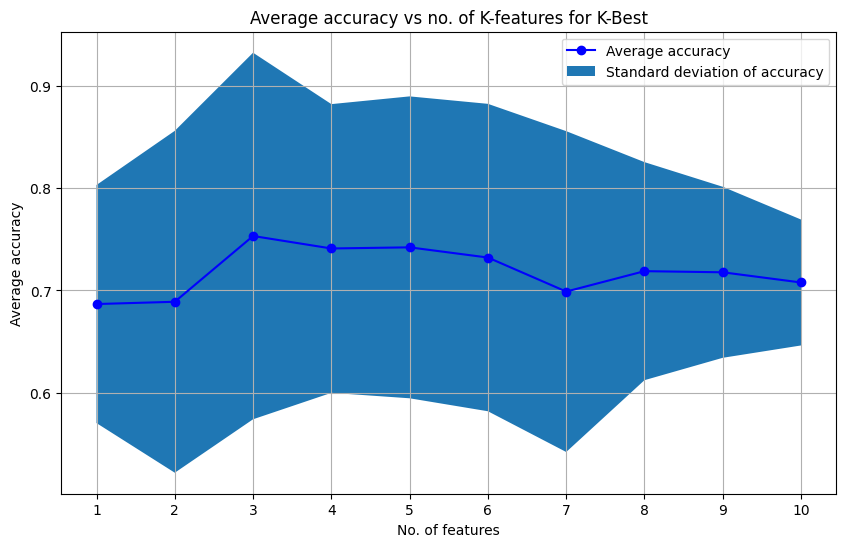

In [67]:
# Evaluating performance of selectkbest feature selection on data set

kf = StratifiedKFold(n_splits=10)
k_values = range(1, 11)
average_accuracies = []
std_accuracies = []

for k in k_values:

    # Select K-best features
    selector = SelectKBest(f_classif, k=k)
    X_train_select = selector.fit_transform(X_train_zv, Y_train)
    accuracies = []

    # 10-fold cross-validation
    for train_index, test_index in kf.split(X_train_select, Y_train):

        X_fold_train, X_fold_test = X_train_select[train_index], X_train_select[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        # Train kNN-model
        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        # Predict and evaluate accuracy
        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    # Calculating average accuracy for current k-number
    average_accuracy = np.mean(accuracies)
    average_accuracies.append(average_accuracy)

    # Calculating standard deviation accuracy for current k-number
    std_accuracy = np.std(accuracies)
    std_accuracies.append(std_accuracy)

    print(f"For k={k} average accuracy is {average_accuracy:.3f} and standard deviation is {std_accuracy:.3f}")

upper_bound = np.array(average_accuracies) + np.array(std_accuracies)
lower_bound = np.array(average_accuracies) - np.array(std_accuracies)

plt.figure(figsize=(10,6))
plt.plot(list(k_values), average_accuracies, marker='o', linestyle='-', color='blue', label='Average accuracy')
plt.fill_between(list(k_values), upper_bound, lower_bound, label='Standard deviation of accuracy')
plt.title('Average accuracy vs no. of K-features for K-Best')
plt.xlabel('No. of features')
plt.ylabel('Average accuracy')
plt.grid(True)
plt.xticks(list(k_values))
plt.legend()
plt.show()

n-components = 1, average accuracy = 0.618 with std dev = 0.135
n-components = 2, average accuracy = 0.598 with std dev = 0.170
n-components = 3, average accuracy = 0.639 with std dev = 0.161
n-components = 4, average accuracy = 0.639 with std dev = 0.136
n-components = 5, average accuracy = 0.652 with std dev = 0.151
n-components = 6, average accuracy = 0.621 with std dev = 0.186
n-components = 7, average accuracy = 0.522 with std dev = 0.107
n-components = 8, average accuracy = 0.490 with std dev = 0.115
n-components = 9, average accuracy = 0.590 with std dev = 0.173
n-components = 10, average accuracy = 0.579 with std dev = 0.156
Explained variance for the first element 0.9961098598299195


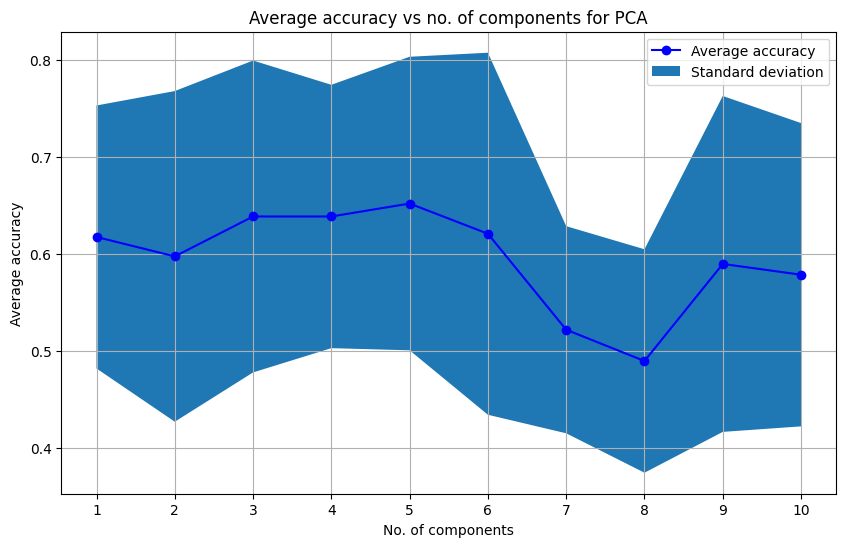

In [68]:
# Evaluating performance of PCA on dataset

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
components = range(1, 11)
average_accuracies = []
std_accuracies = []
plot_proberen = []

for n_components in components:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_zv)
    variance = pca.explained_variance_ratio_

    if n_components == 2:
        plot_proberen.append(X_train_pca)

    accuracies = []

    for train_index, test_index in skf.split(X_train_pca, Y_train):
        X_fold_train, X_fold_test = X_train_pca[train_index], X_train_pca[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    average_accuracies.append(average_accuracy)
    std_dev = np.std(accuracies)
    std_accuracies.append(std_dev)

    print(f"n-components = {n_components}, average accuracy = {average_accuracy:.3f} with std dev = {std_dev:.3f}")

print(f'Explained variance for the first element {variance[0]}')

upper_bound = np.array(average_accuracies) + np.array(std_accuracies)
lower_bound = np.array(average_accuracies) - np.array(std_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(list(components), average_accuracies, marker='o', linestyle='-', color='blue', label='Average accuracy')
plt.fill_between(list(components), upper_bound, lower_bound, label='Standard deviation')
plt.title('Average accuracy vs no. of components for PCA')
plt.xlabel('No. of components')
plt.ylabel('Average accuracy')
plt.grid(True)
plt.xticks(list(components))
plt.legend()
plt.show()

(92, 474)
(23, 474)
(92, 2)
(23, 2)


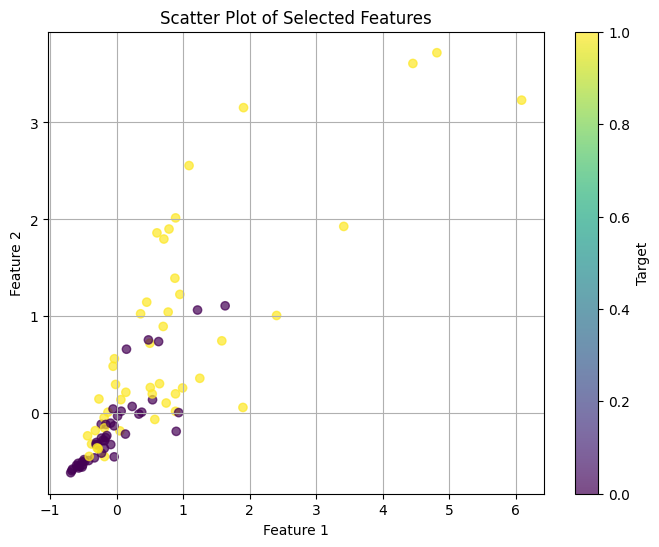

In [74]:
# Applying dimensionality reduction technique with best performance on dataset
print(X_train_zv.shape)
print(X_test_zv.shape)

selector_fs = SelectKBest(f_classif, k=2) #dit veranderen ahv plot

fitted_kbest = selector_fs.fit(X_train_zv, Y_train)

X_train_fs = fitted_kbest.transform(X_train_zv)
X_test_fs = fitted_kbest.transform(X_test_zv)

print(X_train_fs.shape)
print(X_test_fs.shape)

feature1 = X_train_fs[:, 0]
feature2 = X_train_fs[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(feature1, feature2, c=Y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label='Target')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Selected Features')
plt.grid(True)
plt.show()

# Classifiers

In [69]:
# General variables for classifiers
cv = 5

### KNN

In [70]:
knn_model = KNeighborsClassifier()

# Define the parameter grid - WAAROM DEZE
param_grid_knn = {
    'n_neighbors': list(range(1, 60, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Create the grid search object with ROC AUC scoring
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=cv, scoring='roc_auc')

# Fit the grid search to the data
grid_search_knn.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_knn.best_params_)

# Get the best estimator
best_knn_model = grid_search_knn.best_estimator_
print(f'Best estimator: {best_knn_model}')

# see how well model works on train and test data:
predictions_knn_train = best_knn_model.predict(X_train_fs)
print(classification_report(Y_train, predictions_knn_train))

roc_auc_knn_train = roc_auc_score(Y_train, predictions_knn_train)
print('ROC AUC =', roc_auc_knn_train)
accuracy_knn_train = accuracy_score(Y_train, predictions_knn_train)
print('Accuracy =', accuracy_knn_train)

predictions_knn_test = best_knn_model.predict(X_test_fs)
print(classification_report(Y_test, predictions_knn_test))

roc_auc_knn_test = roc_auc_score(Y_test, predictions_knn_test)
print('ROC AUC =', roc_auc_knn_test)
accuracy_knn_test = accuracy_score(Y_test, predictions_knn_test)
print('Accuracy =', accuracy_knn_test)

NameError: name 'X_train_fs' is not defined

### Random forest

In [ ]:
#NB: runnen duurt lang door lijst aan n_estimators!

RF_model = RandomForestClassifier()

# Define the parameter grid - WAAROM DEZE
param_grid_RF = {
    #'n_estimators': list(range(1, 100, 10)), # more estimators probably better result but also more computationally expensive!
    'bootstrap': [True, False],
    'min_samples_leaf': list(range(1, 7, 2))
}

# Create the grid search object with ROC AUC scoring
grid_search_RF = GridSearchCV(RF_model, param_grid_RF, cv=cv, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_RF.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_RF.best_params_)

# Get the best estimator
best_RF_model = grid_search_RF.best_estimator_

print(best_RF_model)

# See how well model works on train and test data:
predictions_RF_train = best_RF_model.predict(X_train_fs)
print(classification_report(Y_train, predictions_RF_train))

roc_auc_RF_train = roc_auc_score(Y_train, predictions_RF_train)
print('ROC AUC =', roc_auc_RF_train)
accuracy_RF_train = accuracy_score(Y_train, predictions_RF_train)
print('Accuracy =', accuracy_RF_train)

predictions_RF_test = best_RF_model.predict(X_test_fs)
print(classification_report(Y_test, predictions_RF_test))

roc_auc_RF_test = roc_auc_score(Y_test, predictions_RF_test)
print('ROC AUC =', roc_auc_RF_test)
accuracy_RF_test = accuracy_score(Y_test, predictions_RF_test)
print('Accuracy =', accuracy_RF_test)

### Support Vector Machine

In [ ]:
# Define the SVM model
svm_model = svm.SVC(probability=True)

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.01, 0.5, 1 ],  # Regularization parameter
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

# Create the grid search object with ROC AUC scoring
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_svm.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_svm.best_params_)

# Get the best estimator
best_svm_model = grid_search_svm.best_estimator_

print(best_svm_model)

# See how well model works on train and test data
predictions_svm_train = best_svm_model.predict(X_train_fs)
print(classification_report(Y_train, predictions_svm_train))

roc_auc_svm_train = roc_auc_score(Y_train, predictions_svm_train)
print('ROC AUC =', roc_auc_svm_train)
accuracy_svm_train = accuracy_score(Y_train, predictions_svm_train)
print('Accuracy =', accuracy_svm_train)

predictions_svm_test = best_svm_model.predict(X_test_fs)
print(classification_report(Y_test, predictions_svm_test))

roc_auc_svm_test = roc_auc_score(Y_test, predictions_svm_test)
print('ROC AUC =', roc_auc_svm_test)
accuracy_svm_test = accuracy_score(Y_test, predictions_svm_test)
print('Accuracy =', accuracy_svm_test)